In [1]:
using Base.Threads
using Distributions
using HypothesisTests
using QuadGK
using Random
using Roots
using StatsBase
using StatsFuns
using StatsPlots
default(fmt=:png, titlefontsize=10, guidefontsize=8, tickfontsize=6)

In [2]:
function prob_x_le_y(distx, disty, a=0.0)
    H(y) = cdf(distx, y) * pdf(disty, y-a)
    quadgk(H, extrema(disty + a)...)[1]
end

function tieshift(distx, disty; probtie=0.5)
    #s = max(std(distx), std(disty))
    #m = median(distx) - median(disty)
    #find_zero(a -> prob_x_le_y(distx, disty, a) - probtie,
    #    (amin, amax), Bisection())
    find_zero(a -> prob_x_le_y(distx, disty, a) - probtie, 0.0)
end

@show tieshift(Normal(0, 1), Normal(2, 2))
@show tieshift(Normal(0, 1), Laplace(2, 2))
@show tieshift(Normal(0, 1), Uniform(0, 1));

tieshift(Normal(0, 1), Normal(2, 2)) = -1.9999999999999232
tieshift(Normal(0, 1), Laplace(2, 2)) = -1.9999999999994498
tieshift(Normal(0, 1), Uniform(0, 1)) = -0.49999999999999983


In [3]:
distx, disty = Gamma(6, 1), Gamma(2, 3)
@show median(distx), median(disty)
@show median(distx) - median(disty)
@show tieshift(distx, disty);

(median(distx), median(disty)) = (5.670161188712071, 5.035040970049984)
median(distx) - median(disty) = 0.6351202186620872
tieshift(distx, disty) = 0.6001914280974744


In [4]:
distx, disty = Uniform(), Chisq(1)
@show median(distx), median(disty)
@show median(distx) - median(disty)
@show tieshift(distx, disty);

(median(distx), median(disty)) = (0.5, 0.4549364231195729)
median(distx) - median(disty) = 0.045063576880427114
tieshift(distx, disty) = -0.02680686952216707


In [5]:
function sim(TestFunc = MannWhitneyUTest;
        distx = Normal(0, 1), disty = Normal(0, 4), m = 100, n = 50,
        L = 10^6)
    pval = Vector{Float64}(undef, L)
    tmpX = [Vector{Float64}(undef, m) for _ in 1:nthreads()]
    tmpY = [Vector{Float64}(undef, n) for _ in 1:nthreads()]
    @threads for i in 1:L
        X = rand!(distx, tmpX[threadid()])
        Y = rand!(disty, tmpY[threadid()])
        pval[i] = pvalue(TestFunc(X, Y))
    end
    pval
    ecdf(pval)
end

distname(dist) = replace(string(dist), r"\{[^\}]*\}"=>"")

function plot_ecdf(ecdf_pval, TestFunc, distx, disty, m, n, a; kwargs...)
    plot(p -> ecdf_pval(p), 0, 0.1; label="ecdf of P-values")
    plot!([0, 0.1], [0, 0.1]; label="", ls=:dot, c=:black)
    plot!(legend=:topleft)
    plot!(xtick=0:0.01:0.1, ytick=0:0.01:1)
    plot!(xguide="nominal significance level α", 
        yguide="probability of P-value < α")
    s = (a < 0 ? "" : "+") * string(round(a; digits=3))
    title!("$TestFunc\n\
        X: $(distname(distx)), m=$m\n\
        Y: $(distname(disty))$s, n=$n")
    plot!(size=(400, 450))
    plot!(; kwargs...)
end

function plot_pvals(
        TestFunc1 = MannWhitneyUTest,
        TestFunc2 = UnequalVarianceTTest;
        distx = Normal(0, 1), disty = Normal(0, 4), m = 100, n = 50,
        L = 10^6, a = nothing, kwargs...)
    
    if isnothing(a)
        @show a = tieshift(distx, disty)
        @show prob_x_le_y(distx, disty + a)
    else
        @show a
        @show median(distx) - median(disty)
    end
    ecdf_pval1 = @time sim(TestFunc1;
        distx = distx,
        disty = disty + a,
        m, n, L, kwargs...)
    ymax1 = ecdf_pval1(0.1)
    @show Δμ = mean(distx) - mean(disty)
    @show mean(distx), mean(disty + Δμ)
    ecdf_pval2 = @time sim(TestFunc2;
        distx = distx,
        disty = disty + Δμ,
        m, n, L, kwargs...)
    ymax2 = ecdf_pval2(0.1)
    ymax = max(ymax1, ymax2)
    P1 = plot_ecdf(ecdf_pval1, TestFunc1, distx, disty, m, n, a;
        ylim=(-0.002, 1.02*ymax), kwargs...)
    P2 = plot_ecdf(ecdf_pval2, TestFunc2, distx, disty, m, n, Δμ;
        ylim=(-0.002, 1.02*ymax), kwargs...)
    plot(P1, P2; size=(800, 450), topmargin=3.5Plots.mm)
end

plot_pvals (generic function with 3 methods)

## 正規分布

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5
  1.827537 seconds (8.02 M allocations: 2.012 GiB, 30.28% gc time, 23.28% compilation time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.549121 seconds (9.42 M allocations: 230.612 MiB, 43.22% compilation time)


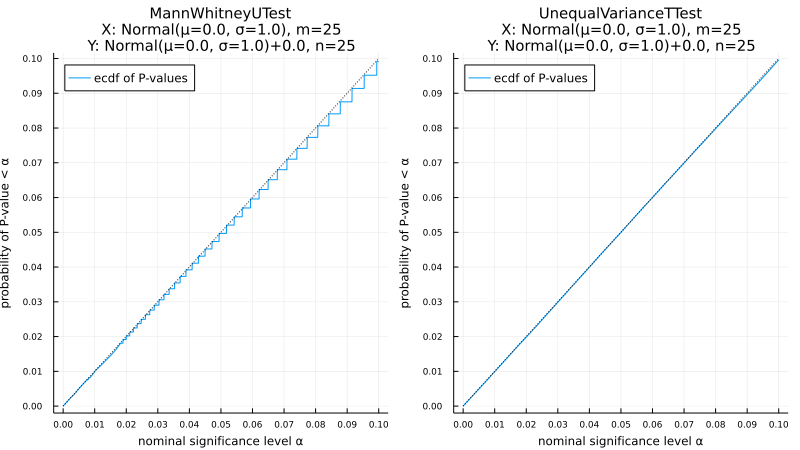

In [6]:
plot_pvals(distx = Normal(0, 1), disty = Normal(0, 1), m = 25, n = 25)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5
  1.470296 seconds (7.00 M allocations: 2.690 GiB, 42.73% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.350688 seconds (9.00 M allocations: 206.012 MiB)


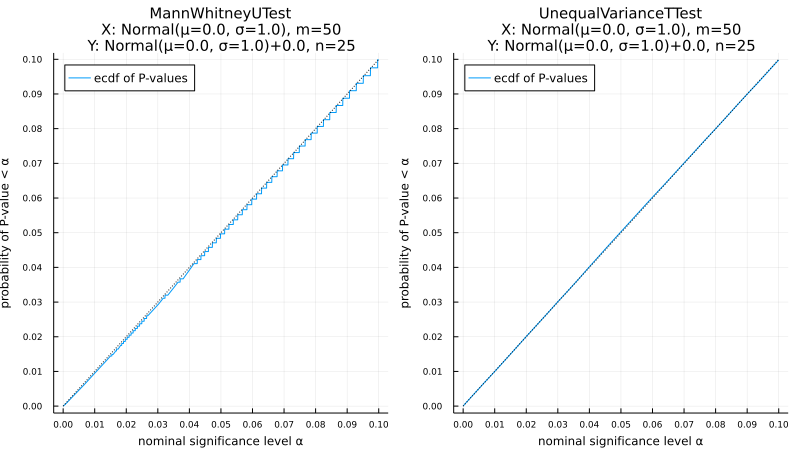

In [7]:
plot_pvals(distx = Normal(0, 1), disty = Normal(0, 1), m = 50, n = 25)

a = tieshift(distx, disty) = 7.685641860444171e-14
prob_x_le_y(distx, disty + a) = 0.5
  1.471110 seconds (7.00 M allocations: 1.960 GiB, 37.32% gc time, 0.31% compilation time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.358977 seconds (9.00 M allocations: 206.009 MiB, 13.98% gc time)


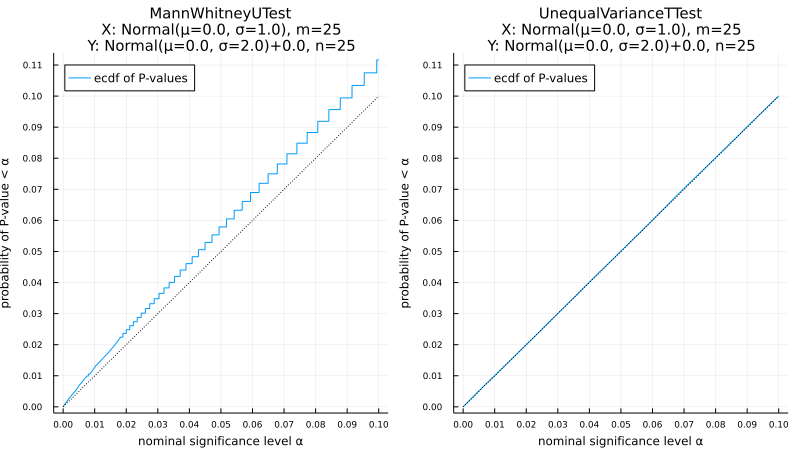

In [8]:
plot_pvals(distx = Normal(0, 1), disty = Normal(0, 2), m = 25, n = 25)

a = tieshift(distx, disty) = 7.685641860444171e-14
prob_x_le_y(distx, disty + a) = 0.5
  1.561875 seconds (7.00 M allocations: 2.690 GiB, 40.16% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.441531 seconds (9.00 M allocations: 206.012 MiB, 15.03% gc time)


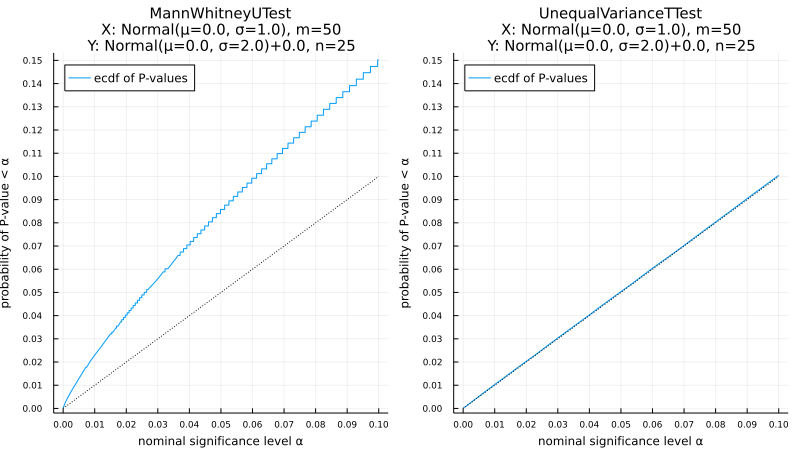

In [9]:
plot_pvals(distx = Normal(0, 1), disty = Normal(0, 2), m = 50, n = 25)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5
  0.688259 seconds (7.00 M allocations: 1014.729 MiB, 33.62% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.318495 seconds (9.00 M allocations: 206.007 MiB)


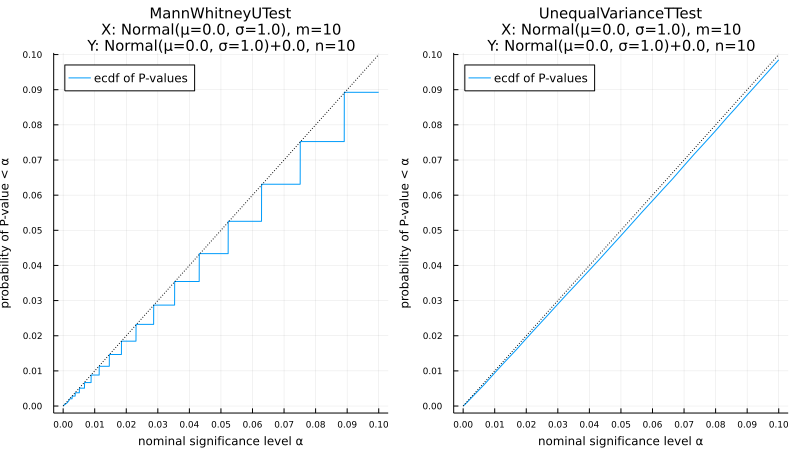

In [10]:
plot_pvals(distx = Normal(0, 1), disty = Normal(0, 1), m = 10, n = 10)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5
  0.978613 seconds (7.00 M allocations: 1.289 GiB, 34.49% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.405501 seconds (9.00 M allocations: 206.008 MiB, 20.37% gc time)


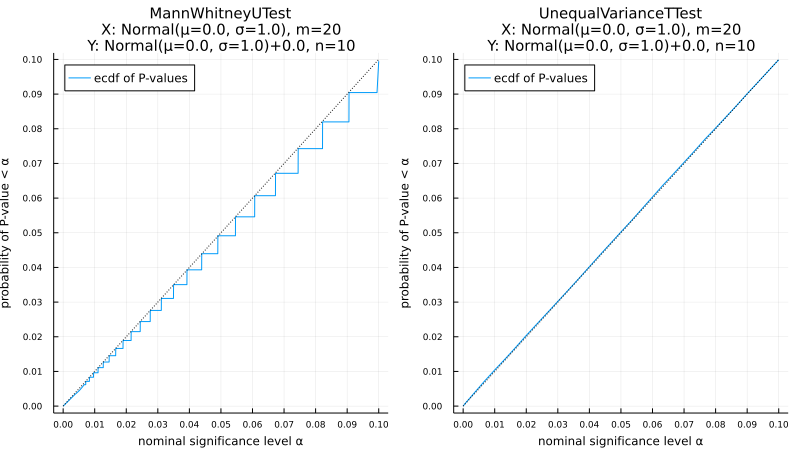

In [11]:
plot_pvals(distx = Normal(0, 1), disty = Normal(0, 1), m = 20, n = 10)

a = tieshift(distx, disty) = 7.685641860444171e-14
prob_x_le_y(distx, disty + a) = 0.5
  0.663983 seconds (7.00 M allocations: 1014.729 MiB, 34.73% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.293561 seconds (9.00 M allocations: 206.006 MiB)


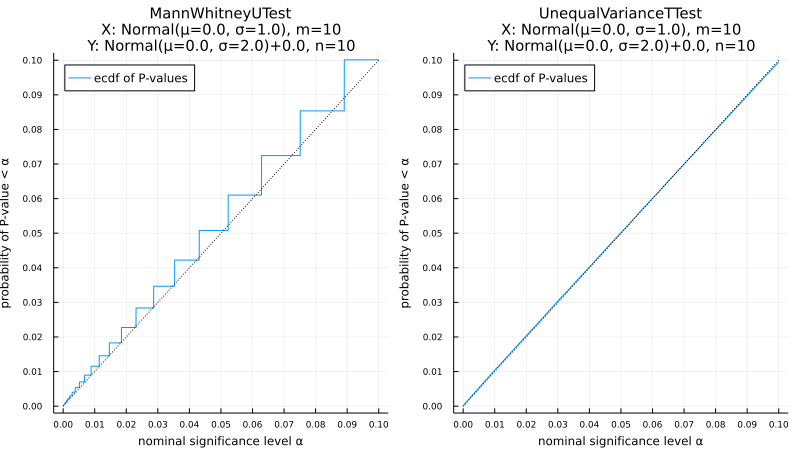

In [12]:
plot_pvals(distx = Normal(0, 1), disty = Normal(0, 2), m = 10, n = 10)

a = tieshift(distx, disty) = 7.685641860444171e-14
prob_x_le_y(distx, disty + a) = 0.5
  0.919120 seconds (7.00 M allocations: 1.289 GiB, 42.71% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.291780 seconds (9.00 M allocations: 206.007 MiB)


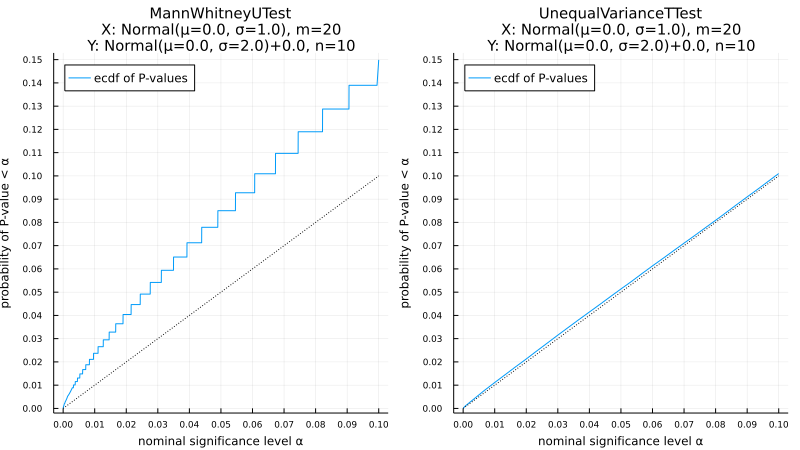

In [13]:
plot_pvals(distx = Normal(0, 1), disty = Normal(0, 2), m = 20, n = 10)

## ガンマ分布

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.49999999999999983
  1.650469 seconds (7.22 M allocations: 1.971 GiB, 23.80% gc time, 8.98% compilation time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (6.0, 6.0)
  0.826311 seconds (9.07 M allocations: 211.142 MiB, 20.06% gc time, 29.70% compilation time)


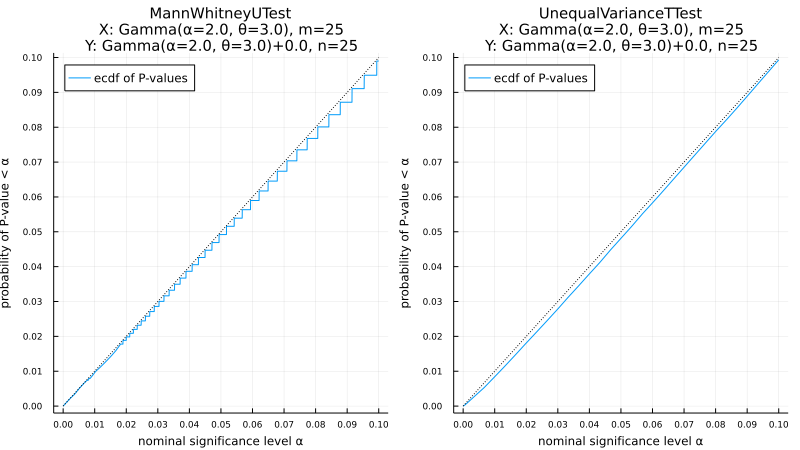

In [14]:
plot_pvals(distx = Gamma(2, 3), disty = Gamma(2, 3), m = 25, n = 25)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.49999999999999983
  1.857406 seconds (7.00 M allocations: 2.690 GiB, 35.43% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (6.0, 6.0)
  0.691524 seconds (9.00 M allocations: 206.012 MiB)


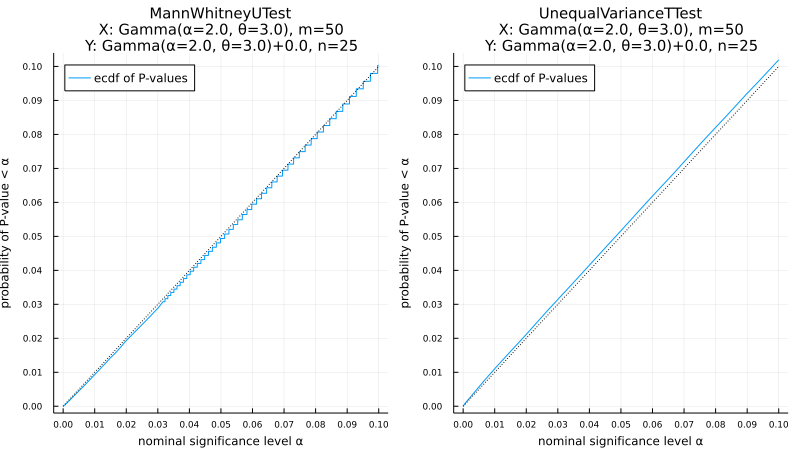

In [15]:
plot_pvals(distx = Gamma(2, 3), disty = Gamma(2, 3), m = 50, n = 25)

a = tieshift(distx, disty) = 0.6001914280974744
prob_x_le_y(distx, disty + a) = 0.5
  1.539172 seconds (7.00 M allocations: 1.960 GiB, 25.89% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (6.0, 6.0)
  0.749272 seconds (9.00 M allocations: 206.009 MiB, 25.40% gc time)


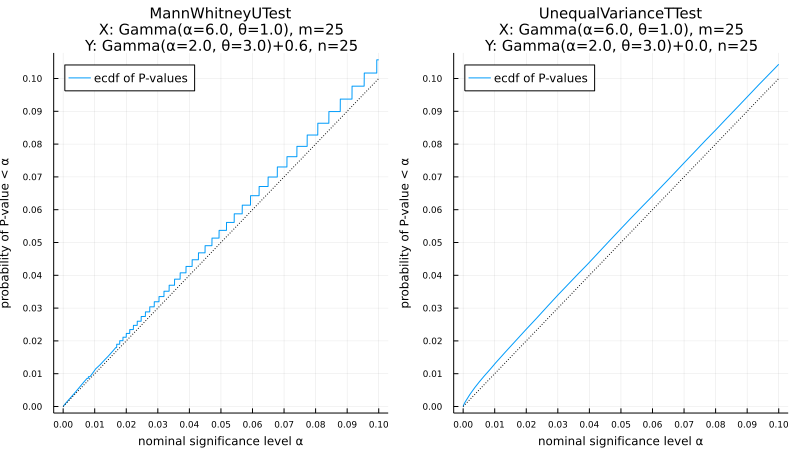

In [16]:
plot_pvals(distx = Gamma(6, 1), disty = Gamma(2, 3), m = 25, n = 25)

a = tieshift(distx, disty) = 0.6001914280974744
prob_x_le_y(distx, disty + a) = 0.5
  1.812817 seconds (7.00 M allocations: 2.690 GiB, 37.57% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (6.0, 6.0)
  0.612538 seconds (9.00 M allocations: 206.012 MiB)


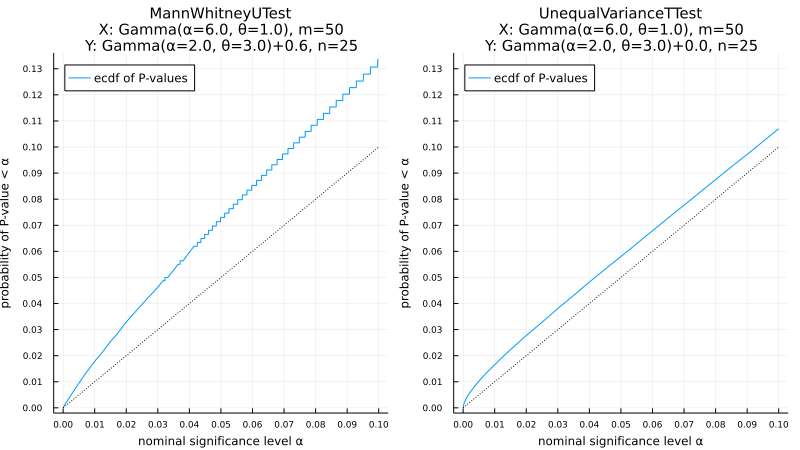

In [17]:
plot_pvals(distx = Gamma(6, 1), disty = Gamma(2, 3), m = 50, n = 25)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.49999999999999983
  0.731418 seconds (7.00 M allocations: 1014.729 MiB, 31.59% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (6.0, 6.0)
  0.385949 seconds (9.00 M allocations: 206.007 MiB)


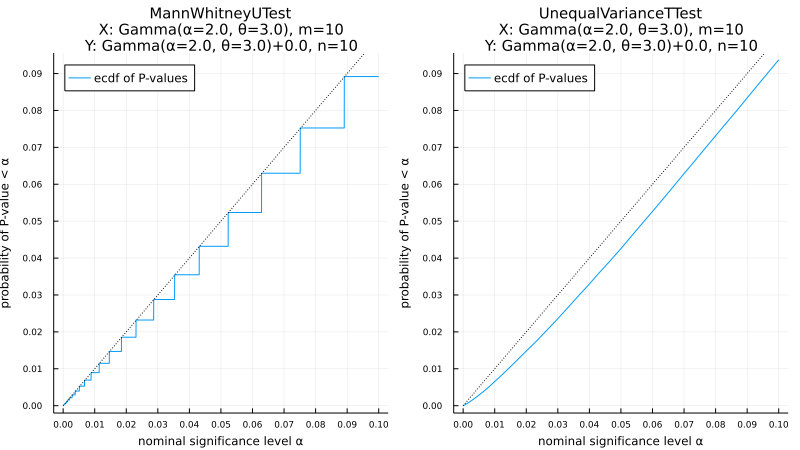

In [18]:
plot_pvals(distx = Gamma(2, 3), disty = Gamma(2, 3), m = 10, n = 10)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.49999999999999983
  0.904955 seconds (7.00 M allocations: 1.289 GiB, 21.35% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (6.0, 6.0)
  0.533973 seconds (9.00 M allocations: 206.008 MiB, 20.10% gc time)


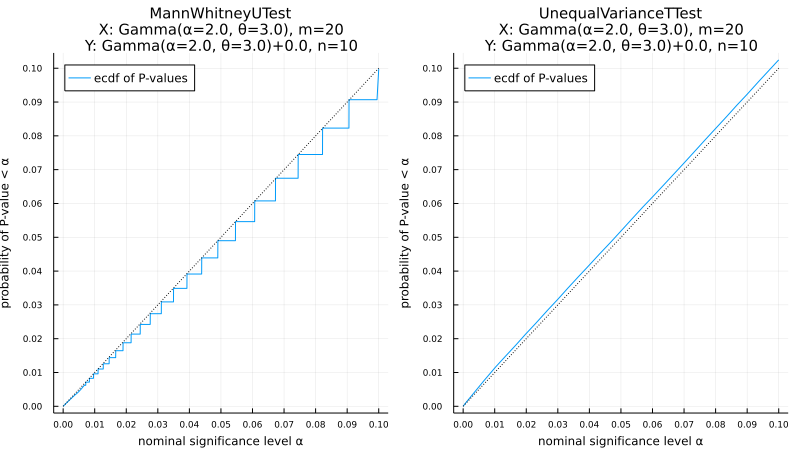

In [19]:
plot_pvals(distx = Gamma(2, 3), disty = Gamma(2, 3), m = 20, n = 10)

a = tieshift(distx, disty) = 0.6001914280974744
prob_x_le_y(distx, disty + a) = 0.5
  0.718593 seconds (7.00 M allocations: 1014.729 MiB, 27.40% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (6.0, 6.0)
  0.376070 seconds (9.00 M allocations: 206.007 MiB)


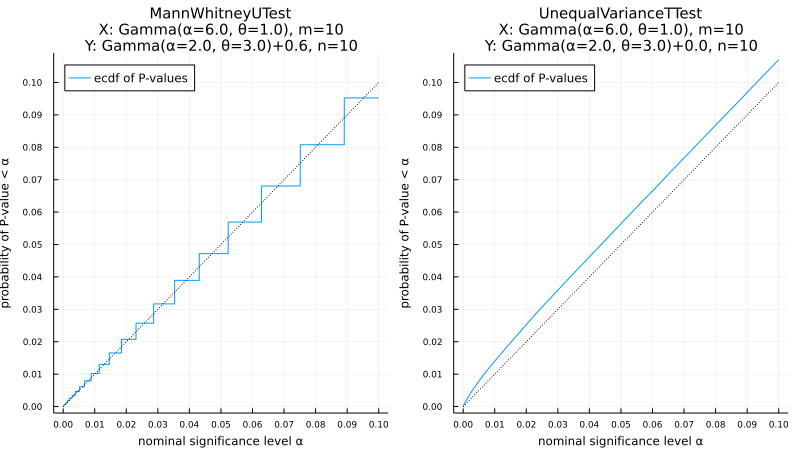

In [20]:
plot_pvals(distx = Gamma(6, 1), disty = Gamma(2, 3), m = 10, n = 10)

a = tieshift(distx, disty) = 0.6001914280974744
prob_x_le_y(distx, disty + a) = 0.5
  0.894503 seconds (7.00 M allocations: 1.289 GiB, 26.35% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (6.0, 6.0)
  0.426613 seconds (9.00 M allocations: 206.007 MiB)


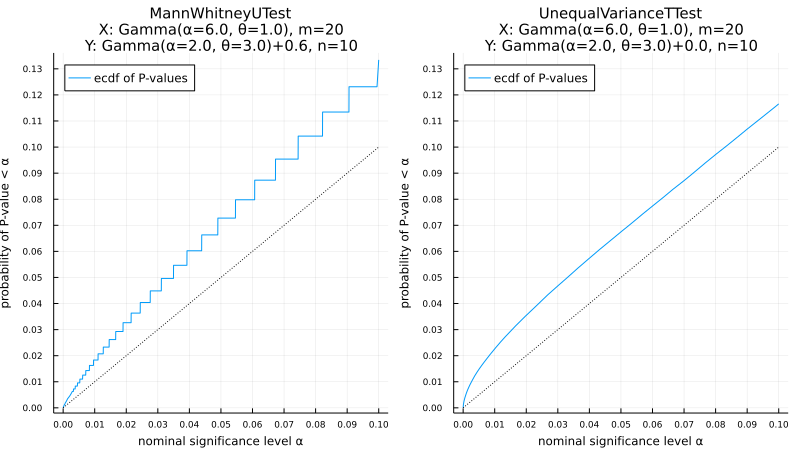

In [21]:
plot_pvals(distx = Gamma(6, 1), disty = Gamma(2, 3), m = 20, n = 10)

## 雑多

a = tieshift(distx, disty) = 2.9690350070884103e-12
prob_x_le_y(distx, disty + a) = 0.5
  0.644866 seconds (7.06 M allocations: 1017.803 MiB, 24.01% gc time, 8.18% compilation time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.391824 seconds (9.07 M allocations: 211.198 MiB, 21.70% compilation time)


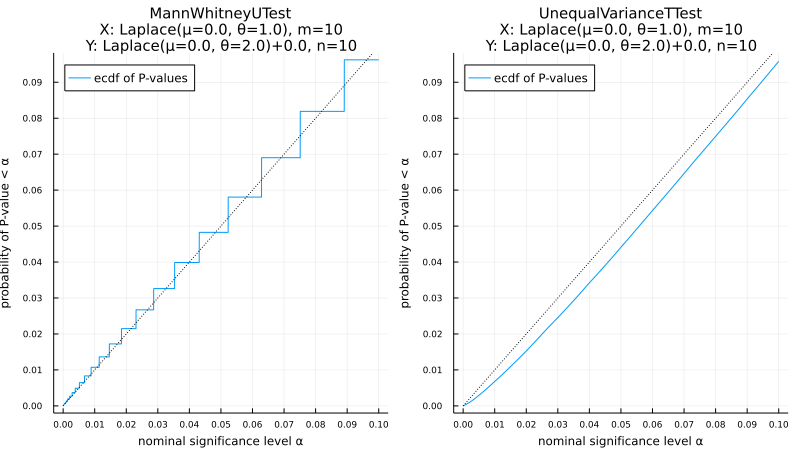

In [22]:
plot_pvals(distx = Laplace(0, 1), disty = Laplace(0, 2), m = 10, n = 10)

a = tieshift(distx, disty) = 2.9690350070884103e-12
prob_x_le_y(distx, disty + a) = 0.5
  1.396835 seconds (7.00 M allocations: 1.960 GiB, 29.71% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.608269 seconds (9.00 M allocations: 206.009 MiB, 36.88% gc time)


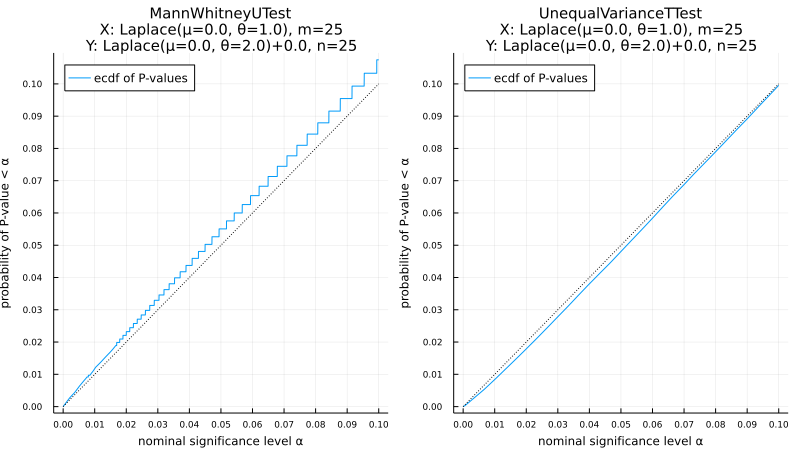

In [23]:
plot_pvals(distx = Laplace(0, 1), disty = Laplace(0, 2), m = 25, n = 25)

a = tieshift(distx, disty) = 2.9690350070884103e-12
prob_x_le_y(distx, disty + a) = 0.5
  2.056133 seconds (7.00 M allocations: 3.539 GiB, 37.42% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.601296 seconds (9.00 M allocations: 206.015 MiB, 19.65% gc time)


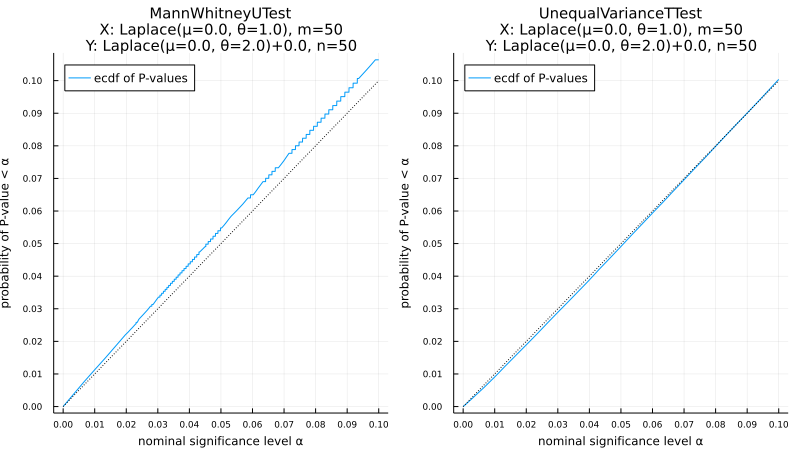

In [24]:
plot_pvals(distx = Laplace(0, 1), disty = Laplace(0, 2), m = 50, n = 50)

a = tieshift(distx, disty) = 2.9690350070884103e-12
prob_x_le_y(distx, disty + a) = 0.5
  0.776029 seconds (7.00 M allocations: 1.289 GiB, 25.14% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.545541 seconds (9.00 M allocations: 206.008 MiB, 33.10% gc time)


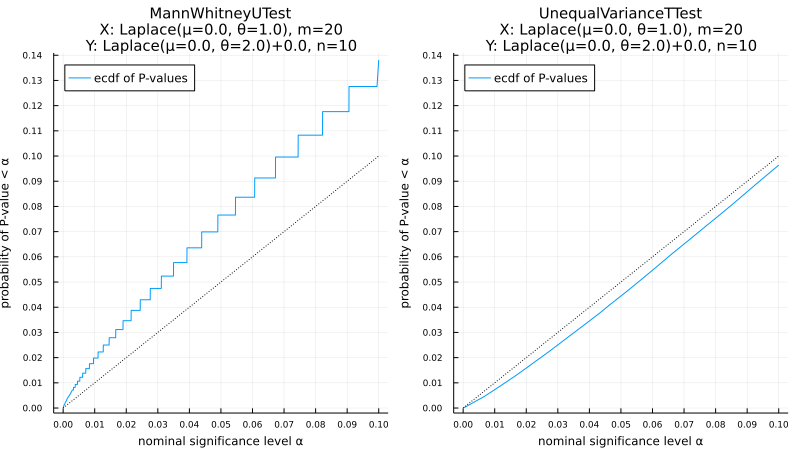

In [25]:
plot_pvals(distx = Laplace(0, 1), disty = Laplace(0, 2), m = 20, n = 10)

a = tieshift(distx, disty) = 2.9690350070884103e-12
prob_x_le_y(distx, disty + a) = 0.5
  1.465079 seconds (7.00 M allocations: 2.690 GiB, 34.69% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.642253 seconds (9.00 M allocations: 206.012 MiB, 35.91% gc time)


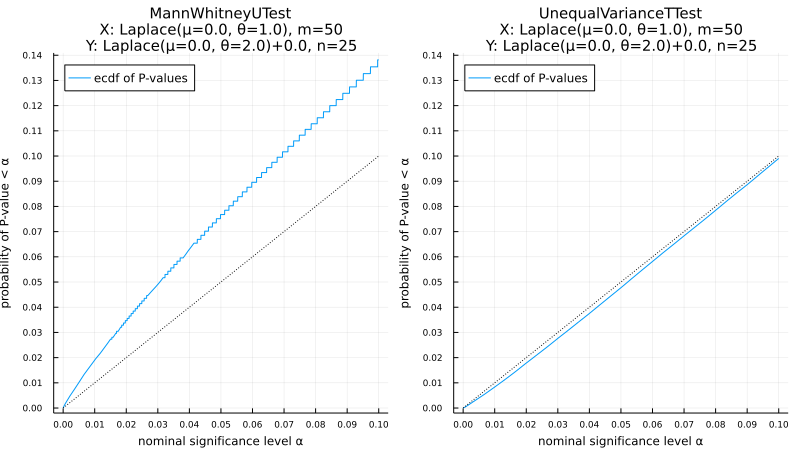

In [26]:
plot_pvals(distx = Laplace(0, 1), disty = Laplace(0, 2), m = 50, n = 25)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5
  0.777960 seconds (7.59 M allocations: 1.018 GiB, 24.69% gc time, 21.44% compilation time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.362799 seconds (9.07 M allocations: 211.052 MiB, 21.98% compilation time)


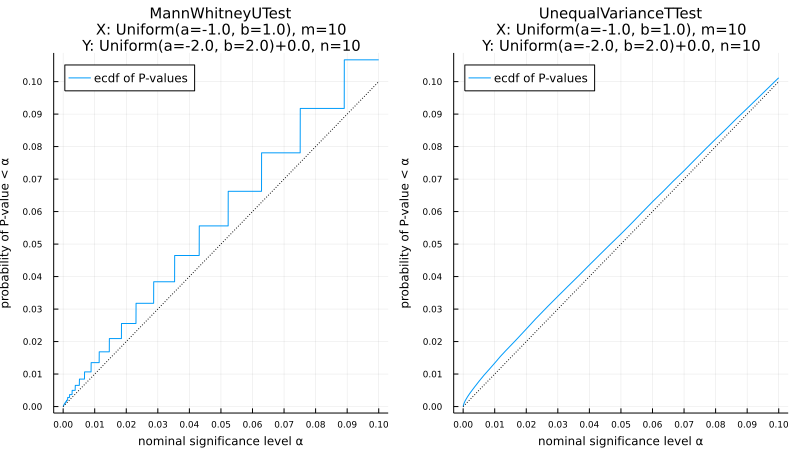

In [27]:
plot_pvals(distx = Uniform(-1, 1), disty = Uniform(-2, 2), m = 10, n = 10)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5
  0.804184 seconds (7.00 M allocations: 1.289 GiB, 29.50% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.301012 seconds (9.00 M allocations: 206.008 MiB)


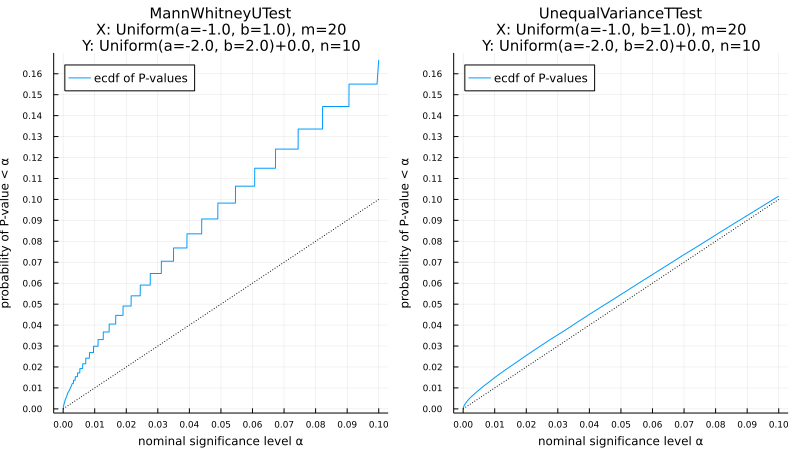

In [28]:
plot_pvals(distx = Uniform(-1, 1), disty = Uniform(-2, 2), m = 20, n = 10)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5
  1.668718 seconds (7.00 M allocations: 2.690 GiB, 48.57% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.321744 seconds (9.00 M allocations: 206.012 MiB)


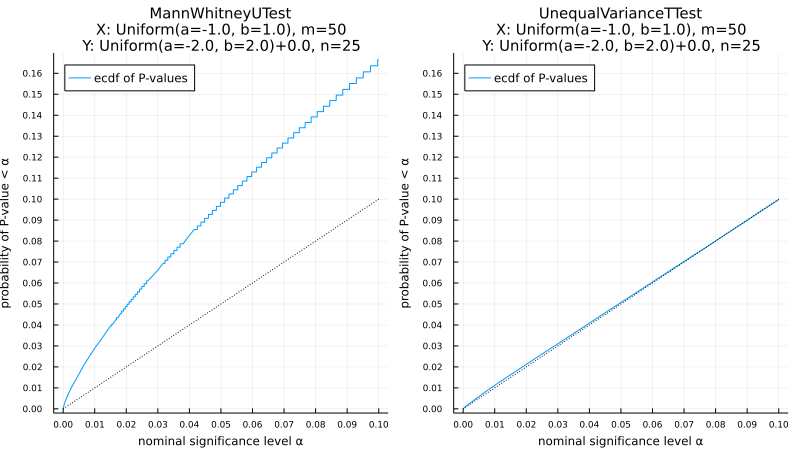

In [29]:
plot_pvals(distx = Uniform(-1, 1), disty = Uniform(-2, 2), m = 50, n = 25)

In [30]:
@doc LogNormal

```
LogNormal(μ,σ)
```

The *log normal distribution* is the distribution of the exponential of a [`Normal`](@ref) variate: if $X \sim \operatorname{Normal}(\mu, \sigma)$ then $\exp(X) \sim \operatorname{LogNormal}(\mu,\sigma)$. The probability density function is

$$
f(x; \mu, \sigma) = \frac{1}{x \sqrt{2 \pi \sigma^2}}
\exp \left( - \frac{(\log(x) - \mu)^2}{2 \sigma^2} \right),
\quad x > 0
$$

```julia
LogNormal()          # Log-normal distribution with zero log-mean and unit scale
LogNormal(μ)         # Log-normal distribution with log-mean mu and unit scale
LogNormal(μ, σ)      # Log-normal distribution with log-mean mu and scale sig

params(d)            # Get the parameters, i.e. (μ, σ)
meanlogx(d)          # Get the mean of log(X), i.e. μ
varlogx(d)           # Get the variance of log(X), i.e. σ^2
stdlogx(d)           # Get the standard deviation of log(X), i.e. σ
```

External links

  * [Log normal distribution on Wikipedia](http://en.wikipedia.org/wiki/Log-normal_distribution)


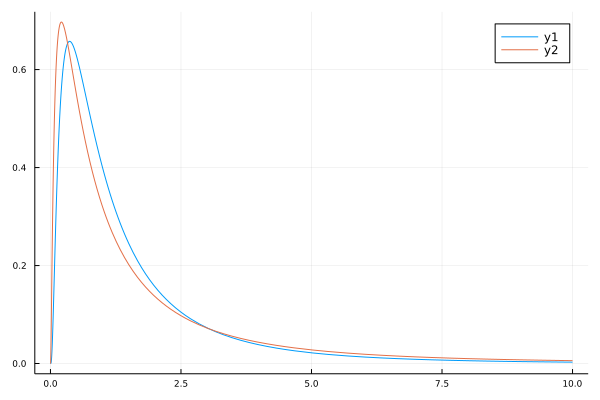

In [31]:
plot(LogNormal(0, 1), 0, 10)
plot!(LogNormal(0, 1.25), 0, 10)

In [32]:
std(LogNormal(0, 1)), std(LogNormal(0, 1.25))

(2.1611974158950877, 4.241363213821604)

a = tieshift(distx, disty) = 7.873419302111289e-12
prob_x_le_y(distx, disty + a) = 0.5
  1.658799 seconds (753.04 k allocations: 3.060 GiB, 34.24% gc time, 3.15% compilation time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (1.6487212707001282, 1.6487212707001282)
  0.338944 seconds (974.24 k allocations: 25.908 MiB, 25.24% compilation time)


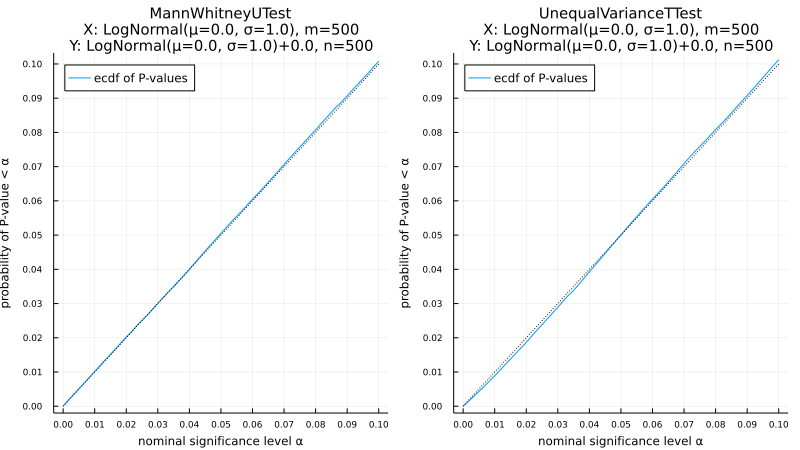

In [33]:
plot_pvals(distx = LogNormal(0, 1), disty = LogNormal(0, 1), m = 500, n = 500, L=10^5)

a = tieshift(distx, disty) = -8.645021886474966e-11
prob_x_le_y(distx, disty + a) = 0.5
  1.817063 seconds (700.20 k allocations: 3.057 GiB, 41.43% gc time)
Δμ = mean(distx) - mean(disty) = -0.5354795401154897
(mean(distx), mean(disty + Δμ)) = (1.6487212707001282, 1.6487212707001282)
  0.266282 seconds (899.69 k allocations: 20.705 MiB)


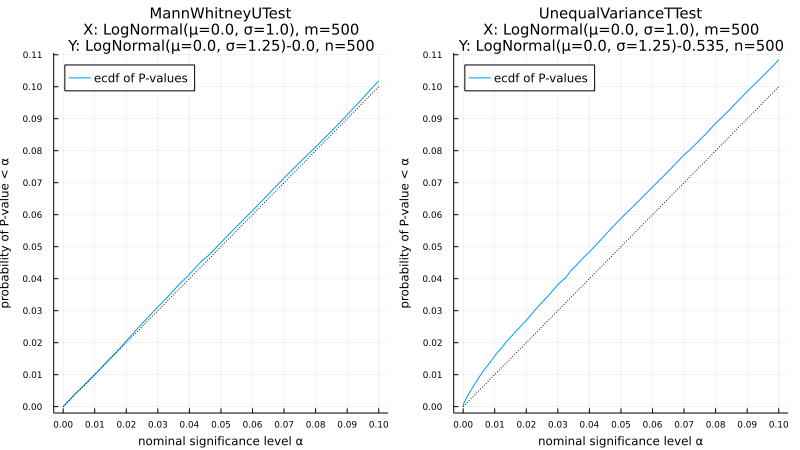

In [34]:
plot_pvals(distx = LogNormal(0, 1), disty = LogNormal(0, 1.25), m = 500, n = 500, L=10^5)

a = tieshift(distx, disty) = -8.645021886474966e-11
prob_x_le_y(distx, disty + a) = 0.5
  2.769483 seconds (700.20 k allocations: 4.553 GiB, 38.89% gc time)
Δμ = mean(distx) - mean(disty) = -0.5354795401154897
(mean(distx), mean(disty + Δμ)) = (1.6487212707001282, 1.6487212707001282)
  0.425776 seconds (899.69 k allocations: 20.750 MiB)


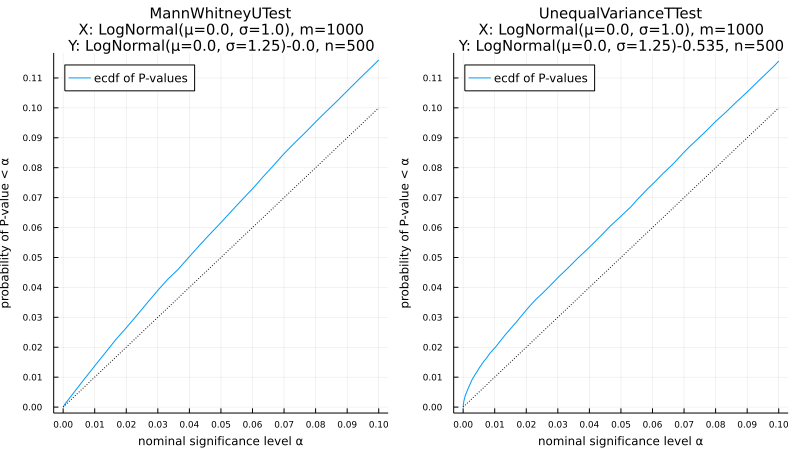

In [35]:
plot_pvals(distx = LogNormal(0, 1), disty = LogNormal(0, 1.25), m = 1000, n = 500, L=10^5)

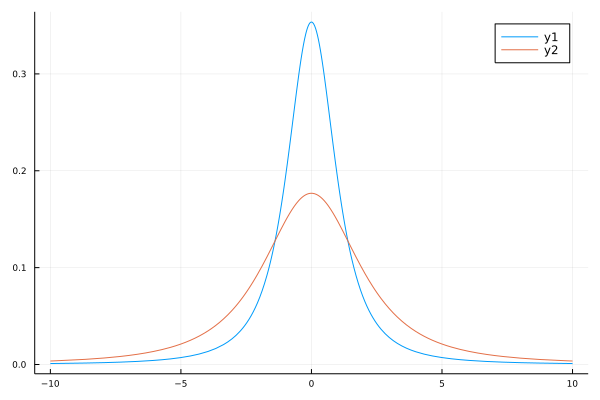

In [36]:
plot(TDist(2), -10, 10)
plot!(2TDist(2), -10, 10)

In [37]:
var(TDist(2)), var(TDist(3)), var(TDist(4)), var(TDist(5))

(Inf, 3.0, 2.0, 1.6666666666666667)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5000000000000001
  4.698105 seconds (7.15 M allocations: 6.840 GiB, 41.85% gc time, 1.44% compilation time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  1.246150 seconds (9.07 M allocations: 211.228 MiB, 7.03% gc time, 6.97% compilation time)


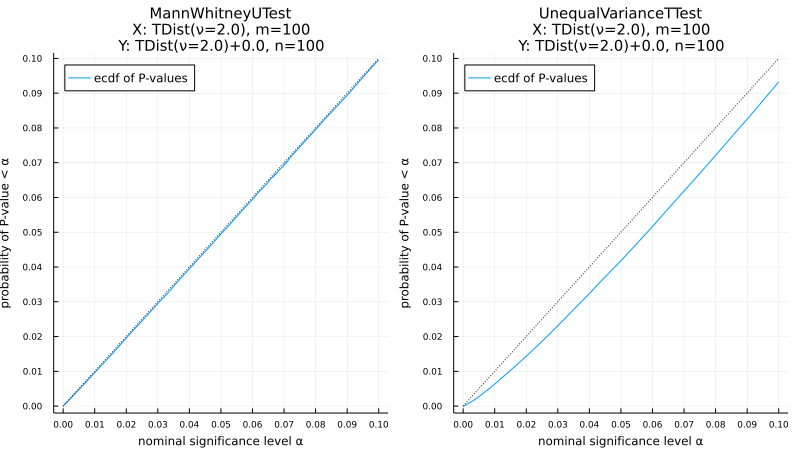

In [38]:
plot_pvals(distx = TDist(2), disty = TDist(2), m = 100, n = 100)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5000000000000001
  5.015558 seconds (7.00 M allocations: 9.783 GiB, 30.29% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  1.591591 seconds (9.00 M allocations: 206.034 MiB, 5.73% gc time)


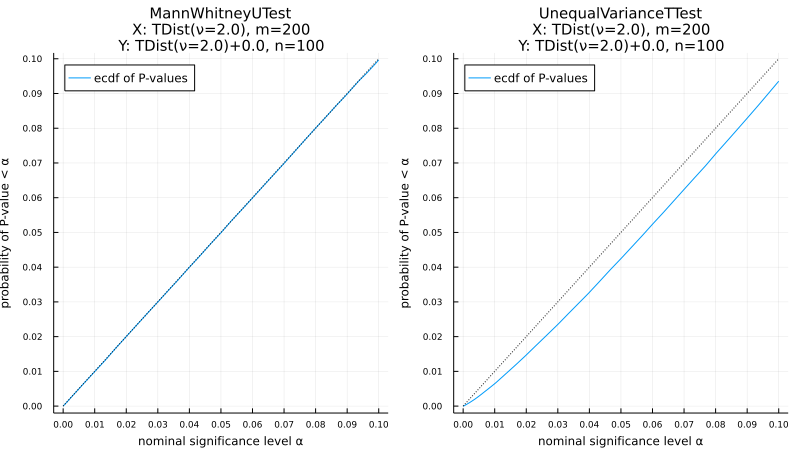

In [39]:
plot_pvals(distx = TDist(2), disty = TDist(2), m = 200, n = 100)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5000000000000002
  4.396565 seconds (7.00 M allocations: 6.832 GiB, 39.99% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  1.209841 seconds (9.00 M allocations: 206.024 MiB, 9.19% gc time)


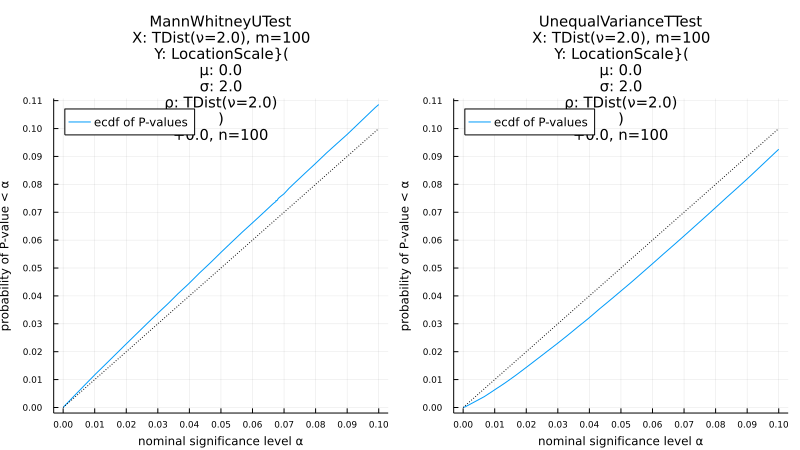

In [40]:
plot_pvals(distx = TDist(2), disty = 2TDist(2), m = 100, n = 100)

a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5000000000000002
  5.141941 seconds (7.00 M allocations: 9.783 GiB, 31.44% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  1.490042 seconds (9.00 M allocations: 206.035 MiB, 3.13% gc time)


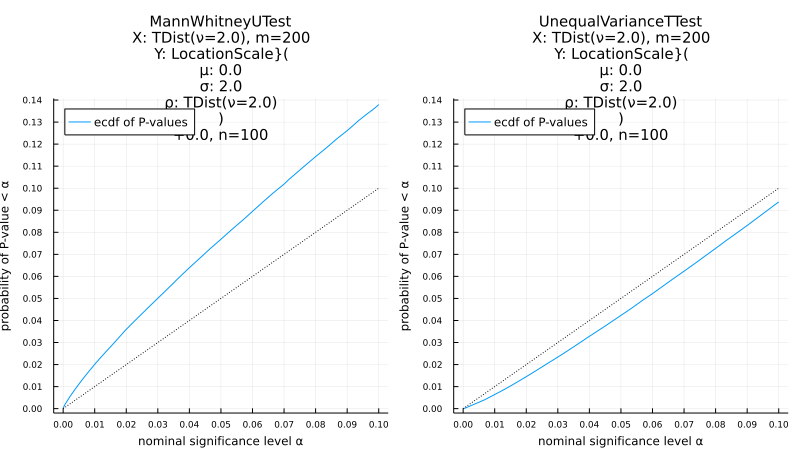

In [41]:
plot_pvals(distx = TDist(2), disty = 2TDist(2), m = 200, n = 100)

## median matching vs. tie shifting

a = tieshift(distx, disty) = -0.8414056600399943
  3.964663 seconds (7.19 M allocations: 6.842 GiB, 44.18% gc time, 1.86% compilation time)
a = median(distx) - median(disty) = -0.6931471805599453
  3.852033 seconds (7.00 M allocations: 6.832 GiB, 43.29% gc time)


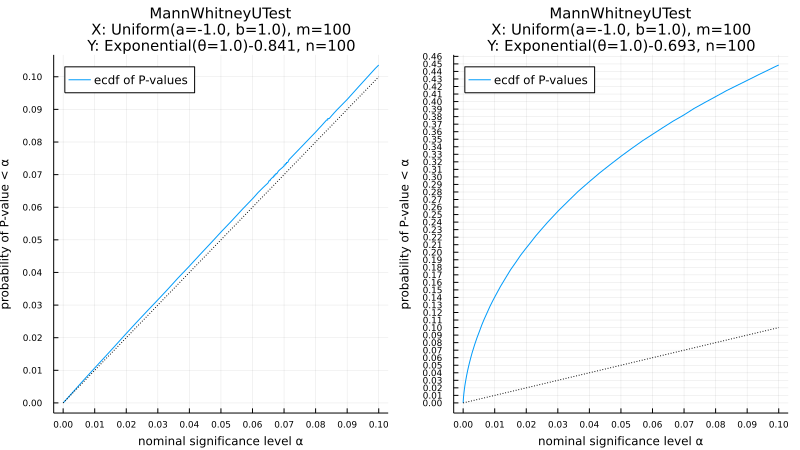

In [42]:
distx, disty = Uniform(-1, 1), Exponential()
m, n, = 100, 100

@show a = tieshift(distx, disty)
ecdf_pval1 = @time sim(; distx = distx, disty = disty + a, m, n)
P1 = plot_ecdf(ecdf_pval1, MannWhitneyUTest, distx, disty, m, n, a)

@show a = median(distx) - median(disty)
ecdf_pval2 = @time sim(; distx = distx, disty = disty + a, m, n)
P2 = plot_ecdf(ecdf_pval2, MannWhitneyUTest, distx, disty, m, n, a)

plot(P1, P2; size=(800, 450), topmargin=4Plots.mm)

(distx, std(distx)) = (Uniform{Float64}(a=-1.0, b=1.0), 0.5773502691896257)
(disty, std(disty)) = (Exponential{Float64}(θ=1.0), 1.0)
tieshift(distx, disty) = -0.8414056600399943
median(distx) - median(disty) = -0.6931471805599453


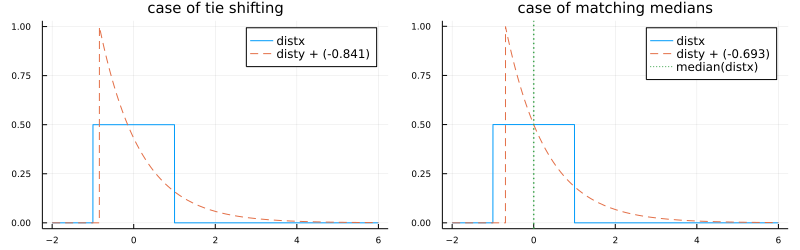

In [43]:
distx, disty = Uniform(-1, 1), Exponential()
@show distx, std(distx)
@show disty, std(disty)

a = @show tieshift(distx, disty)
P1 = plot(distx, -2, 6; label="distx")
plot!(disty + a, -2, 6; label="disty + ($(round(a; digits=3)))", ls=:dash)
title!("case of tie shifting")

a = @show median(distx) - median(disty)
P2 = plot(distx, -2, 6; label="distx")
plot!(disty + a, -2, 6; label="disty + ($(round(a; digits=3)))", ls=:dash)
vline!([median(distx)]; label="median(distx)", ls=:dot, lw=1.5)
title!("case of matching medians")

plot(P1, P2; size=(800, 250))